# English To Hindi Translation Model

The aim is to develop a translation model based on an encoder-decoder model architecture using LSTMs. The dataset used is the IIT Bombay English to Hindi translation dataset. 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install contractions

   ---------------------------------------- 0.0/289.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/289.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/289.9 kB 660.6 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/289.9 kB 544.7 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/289.9 kB 731.4 kB/s eta 0:00:01
   ------------------ ------------------- 143.4/289.9 kB 711.9 kB/s eta 0:00:01
   ------------------------- ------------ 194.6/289.9 kB 787.7 kB/s eta 0:00:01
   ----------------------------- -------- 225.3/289.9 kB 811.5 kB/s eta 0:00:01
   -------------------------------------  286.7/289.9 kB 886.2 kB/s eta 0:00:01
   -------------------------------------- 289.9/289.9 kB 852.7 kB/s eta 0:00:00


In [5]:
!pip install wordcloud

   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   -------- ------------------------------- 61.4/300.2 kB 1.1 MB/s eta 0:00:01
   -------------------------------- ------- 245.8/300.2 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.3 MB/s eta 0:00:00


In [7]:
!pip install spacy

   ---------------------------------------- 0.0/12.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.1 MB 991.0 kB/s eta 0:00:13
   ---------------------------------------- 0.1/12.1 MB 1.1 MB/s eta 0:00:12
   ---------------------------------------- 0.1/12.1 MB 871.5 kB/s eta 0:00:14
    --------------------------------------- 0.2/12.1 MB 926.0 kB/s eta 0:00:13
    --------------------------------------- 0.2/12.1 MB 935.2 kB/s eta 0:00:13
    --------------------------------------- 0.3/12.1 MB 911.0 kB/s eta 0:00:13
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/12.1 MB 983.9 k

In [2]:
import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import indian
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import unicodedata
from keras.models import Sequential,Model
from keras.layers import Input,Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import spacy
import contractions
from nltk.corpus import stopwords
import numpy as np
import pandas as pd 

### Importing dataset

In [5]:
data = pd.read_csv("newdata.csv")

In [6]:
data.head()

,english,hindi
0,"On the other hand , it has been observed that ...",इसके विपरीत देखा यह गया है कि उपयुक़्त आयु में...
1,Now we may find that there are places that are...,अब यह भी हो सकता है कि हमें ऐसे स्थान मिलें जो...
2,He has never told a lie.,उसने कभी झूठ नही बोला है.
3,I can tell you it's a magnificent spread.,मैं आप को बता सकता हूँ कि वो बहुत ही भव्य है॰
4,And one of them came to me the next morning an...,"और उनमें से एक मेरे पास अगली सुबह आया और बोला,"


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   english   1210 non-null   object
 1   hindi     1206 non-null   object
dtypes: object(2)
memory usage: 19.0+ KB


In [8]:
data.describe()

,english,hindi
count,1210,1206
unique,1199,1194
top,(Laughter),(हंसी)
freq,7,4


### Data Preprocessing 

In [9]:
data.isnull().sum()

english     0
hindi       4
dtype: int64

In [10]:
data.dropna(inplace = True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1206 entries, 0 to 1209
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   english   1206 non-null   object
 1   hindi     1206 non-null   object
dtypes: object(2)
memory usage: 28.3+ KB


In [12]:
data.sample(10)

,english,hindi
251,Haj - this is a religious travel done at the e...,तीर्थ यात्रा (हज)- हज उस धार्मिक तीर्थ यात्रा ...
135,A . I believe it is in the interest of the peo...,"मेरा मानना है कि जनता , देश और सामाजिक सुधारों..."
342,The pillars inside the mandapa are exquisitely...,मंडप के भीतर के स्तंभ उत्कृष्ट रूप से खराद पर ...
575,"From early times , the decisions of Panchayats...","आरंभिक काल से ही , पंचायतों के निर्णयों को बाध..."
393,Fruit,फल
1022,it is mentioned four apologias for a descripti...,एक विश्लेषण अमेरिकी खुफिया के लिए तैयार में चा...
190,This is free WiFi.,ये फ्री वाई-फाई है.
8,Most of the Puranas are named after Vishnu and...,अधिकांश पूराण विष्णु के नाम से हैं और कुछ ब्रह...
664,"In August 2006, The Wall Street Journal publis...",अगस्त २००६ मेंवाल स्ट्रीट जर्नल (The Wall Stre...
807,"The cultural history of India , as of other co...",अन्य देशों की भांति भारत के सांस्कृतिक इतिहास ...


In [11]:
#now we need to preprocess the text ---> remove punctuations, contractions, html tags, urls etc. 

In [12]:
#remove html tags 

In [13]:
def remove_html(text):
    if isinstance(text,str):
        pattern = re.compile('<.*?>')
        return pattern.sub(r'',text)
    else:
        return text

In [14]:
# remove url

In [14]:
def remove_url(text):
    if isinstance(text,str):
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return pattern.sub(r'',text)
    else:
        return

In [16]:
# remove alphanumeric characters

In [15]:
def preprocess_text(text, language='english'):
    if not isinstance(text, str):
        return text
    if language == 'english':
        pattern = re.compile(r'[^a-zA-Z0-9\s]')
        return pattern.sub(r'', text)
    elif language == 'hindi':
        pattern = re.compile(r'[^\u0900-\u097F\s]')
        return pattern.sub(r'', text)
    else:
        raise ValueError("Unsupported Language, Supported languages are 'english' and 'hindi'")

In [18]:
data.rename(columns = {'english ' : 'english'}, inplace = True)

In [19]:
data.columns

Index(['english', 'hindi'], dtype='object')

In [20]:
data['english'] = data['english'].apply(remove_html)

In [21]:
data["hindi"] = data["hindi"].apply(remove_html)

In [22]:
data['english'] = data['english'].apply(remove_url)
data["hindi"] = data["hindi"].apply(remove_url)

In [23]:
data['english'] = data['english'].apply(lambda x: preprocess_text(x, language='english'))
data['hindi'] = data['hindi'].apply(lambda x: preprocess_text(x, language='hindi'))

In [22]:
# at this stage we don't have any html tags, url tags and alphanumeric characters

In [23]:
#now we need to remove punctuations before tokenising the texts 

In [24]:
#English punctuations

In [24]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
def get_hindi_punctuations():
    hindi_punctuations = []
    for i in range(0x2000, 0x206f + 1):
        char = chr(i)
        if unicodedata.category(char) == 'Po':
            hindi_punctuations.append(char)
    return ''.join(hindi_punctuations)

In [26]:
hindi_punctuation = get_hindi_punctuations()

In [27]:
hindi_punctuation

'‖‗†‡•‣․‥…‧‰‱′″‴‵‶‷‸※‼‽‾⁁⁂⁃⁇⁈⁉⁊⁋⁌⁍⁎⁏⁐⁑⁓⁕⁖⁗⁘⁙⁚⁛⁜⁝⁞'

In [28]:
def remove_punctuation(text, language = 'english'):
    if language == 'english':
        exclude_english = set(string.punctuation)
        return ''.join(char for char in text if char not in exclude_english)
    elif language == 'hindi':
        return ''.join(char for char in text if char not in hindi_punctuation)
    
    else:
        raise ValueError("Unsupported Language, Supported languages are 'english' and 'hindi'")

In [29]:
data['english'] = data['english'].apply(lambda x: remove_punctuation(x,language = 'english'))
data['hindi'] = data['hindi'].apply(lambda x: remove_punctuation(x,language = 'hindi'))

In [30]:
def expand_contractions(text):
    expanded_text = contractions.fix(text)
    return expanded_text

In [31]:
data["english"] = data["english"].apply(expand_contractions)

In [33]:
# data is now clean and ready to be tokenised

In [32]:
def do_tokenization(text):
    token_words = word_tokenize(text)
    return token_words

In [33]:
data["english"] = data["english"].apply(do_tokenization)
data["hindi"] = data["hindi"].apply(do_tokenization)

In [35]:
data['english'][500]

['Hindi', 'Poet']

In [36]:
data["hindi"][500]

['हिन्दी', 'कवि']

In [38]:
# now amongst these we need to remove the stop words

In [37]:
len(stopwords.words("english"))

179

In [38]:
nltk.download("indian")

[nltk_data] Downloading package indian to C:\Users\Diya
[nltk_data]     Sivaprasad\AppData\Roaming\nltk_data...
[nltk_data]   Package indian is already up-to-date!


True

In [39]:
len(nltk.corpus.indian.words('hindi.pos'))

9408

In [42]:
# collecting the stopwords

In [40]:
stop_words_english = set(stopwords.words('english'))
stop_words_hindi = set(nltk.corpus.indian.words('hindi.pos'))

In [41]:
# function to remove stopwords

In [42]:
def remove_stopwords(text,language = 'english'):
    if language == 'english':
        filtered_words_english = [word for word in text if word.lower() not in stop_words_english]
        return ' '.join(filtered_words_english)
    elif language == 'hindi':
        filterd_words_hindi = [word for word in text if word not in stop_words_hindi]
        return ' '.join(filterd_words_hindi)
    else:
        return ValueError("Unsupported Language, Supported languages are 'english' and 'hindi'")

In [43]:
data['english'] = data['english'].apply(lambda x :remove_stopwords(x,language = 'english'))
data['hindi'] = data['hindi'].apply(lambda x :remove_stopwords(x,language = 'hindi'))

In [44]:
data.sample(5)

,english,hindi
22,Since already held Legislative Assembly power ...,विधान मानहानि याचिकादाता विरुद्ध शक्ति अनुच्छे...
107,Delhi visit made memorable Gandhi generous lov...,उदार मनोभावों रवीन्द्रनाथ स्वास्थ्य व्यग्रता न...
1189,sometimes people outside UK imagine,क्योकि
137,words matchfixer scratched bonnet Mitsubishi L...,मित्सुबिशी लंसर बोनट खुरचकर फिक्सर शद गाड़ी पे...
852,Somebody care achievements,आपकी उपलब्धियों परवाह


In [48]:
# now we need to convert words into their root forms ---> via the process of stemming

In [45]:
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    return [ps.stem(word) for word in words]

In [46]:
data["english"] = data["english"].apply(stemming)
data["hindi"] = data["hindi"].apply(stemming)

In [47]:
data.sample(5)

,english,hindi
141,"[student, work]","[वहाँ, छात्र]"
81,"[troubl, kid]",[बच्चा]
923,"[difficulti, way, modernis, mani, lack, fund, ...","[आधुनिकीकरण, बाधाएं, विशेषकर, विदेशी, मुद्रा, ..."
508,"[agra, aligarh, ayodhya, bareilli, meerut, var...","[आगरा, अलीगढ, अयोध्या, बरेली, मेरठ, बनारस, गोर..."
112,"[1938, particularli, sinc, begin, 1939, bitter...","[सन्, खासकर, दक्षिणपंथी, कांग्रेसियों, सुभाष, ..."


In [52]:
# we are done with the data pre-processing 

### Tokenisation

In [48]:
tokenizer_english = Tokenizer()

In [49]:
tokenizer_english.fit_on_texts(data["english"])

In [50]:
tokenizer_hindi = Tokenizer()

In [51]:
tokenizer_hindi.fit_on_texts(data["hindi"])

In [52]:
tokenizer_hindi.word_index['<start>'] = len(tokenizer_hindi.word_index) + 1
tokenizer_hindi.word_index['<end>'] = len(tokenizer_hindi.word_index) + 1

In [53]:
def add_special_tokens(sequences, start_token='<start>', end_token='<end>'):
    sequences_with_special_tokens = []
    for sequence in sequences:
        sequence_with_special_tokens = [start_token] + sequence + [end_token]
        sequences_with_special_tokens.append(sequence_with_special_tokens)
    return sequences_with_special_tokens

In [54]:
data['hindi'] = add_special_tokens(data['hindi'])

In [55]:
data.sample(10)

,english,hindi
94,"[5, type, doubt, least, 368, doubt, clear, nee...","[<start>, संविधान, मे, संशोधन, शक्ति, अनु, अनु..."
131,"[pistol, use, kill, jackson, strenuous, conten...","[<start>, पिस्तौल, संबंध, जिससे, जैक्सन, हत्या..."
585,"[known, muslim, catastroph, day]","[<start>, मुसलमान, प्रलय, हैं।, <end>]"
23,"[mustach, grow, abil]","[<start>, अनडरएस्टीमेट, <end>]"
430,"[instead, prevent, delist, mnc, need, introspe...","[<start>, भराष्ट्रीय, कंपनियों, शेयर, बाजार, ह..."
1149,"[allow, suffici, rest]","[<start>, पर्याप्त, विश्राम, <end>]"
989,"[peopl, start, contribut, idea]","[<start>, विचारों, प्रारंभ, <end>]"
206,"[select, staff, ats107, second, flight, 2000]","[<start>, एसटीएस१०७, उड़ान, चुना, गया।, <end>]"
725,"[mahoba, district]","[<start>, महोबा, जिला, <end>]"
773,"[januari, 2005, south, africa, england]","[<start>, <end>]"


In [56]:
data["english"] = tokenizer_english.texts_to_sequences(data["english"])
data["hindi"] = tokenizer_hindi.texts_to_sequences(data["hindi"])

In [57]:
data.sample(10)

,english,hindi
565,"[2836, 2837]","[4582, 2897, 2898, 4583]"
962,"[907, 70, 3562, 525, 943]","[4582, 219, 3913, 1117, 3914, 4583]"
296,"[1238, 503, 2253, 837]","[4582, 814, 2072, 2073, 2074, 4583]"
797,"[251, 1117, 7, 625, 321]","[4582, 3481, 3482, 4583]"
1140,"[540, 664, 233, 3875, 553, 1503, 3876]","[4582, 912, 4369, 4370, 481, 4583]"
880,"[85, 69, 3404, 3405, 3406, 68, 203, 622, 280]","[4582, 26, 3710, 3711, 3712, 3713, 12, 1020, 1..."
329,"[343, 355, 140, 2310, 130, 277, 71, 2311, 2, 1...","[4582, 425, 2162, 111, 43, 470, 43, 835, 2163,..."
205,"[445, 2060, 795, 1167, 245, 2061, 128, 2062]","[4582, 1809, 1810, 1811, 4583]"
95,"[1775, 8, 541, 722, 1, 91, 179, 2, 723, 185, 1...","[4582, 1417, 630, 15, 1418, 75, 4583]"
1029,"[251, 154, 13, 3677]","[4582, 4091, 4092, 4583]"


In [64]:
#now we can go ahead with the train and test split part

### Model Training 

In [60]:
x_train, x_test, y_train, y_test = train_test_split(data["english"], data["hindi"], test_size = 0.2, random_state = 42)

In [61]:
print(len(x_train))
print(len(x_test))

964
242


In [62]:
print(len(y_train))
print(len(y_test))

964
242


In [112]:
# now we add padding to the data 

In [63]:
def max_sequence_length(text):
    combined_sequences = text
    max_length_combined = max(len(sequence) for sequence in combined_sequences)
    return max_length_combined

In [64]:
max_length_x = max_sequence_length(data["english"])
max_length_y = max_sequence_length(data["hindi"])

In [65]:
max_length_x

124

In [66]:
max_length_y

92

In [67]:
x_train.shape

(964,)

In [68]:
x_train_new = pad_sequences(x_train, maxlen = max_length_x, padding = 'post')
y_train_new = pad_sequences(y_train, maxlen = max_length_y, padding = 'post')
x_test_new = pad_sequences(x_test, maxlen = max_length_x, padding = 'post')
y_test_new = pad_sequences(y_test, maxlen = max_length_y, padding = 'post')

In [69]:
#establishing the model 

In [70]:
def create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, hidden_units):
    ## encoder
    encoder_inputs = Input(shape=(max_seq_length_input,))
    encoder_embedding = Embedding(input_dim=vocab_size_input, output_dim=embedding_dim)(encoder_inputs)
    encoder_lstm = LSTM(hidden_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]
    
    ## decoder
    decoder_inputs = Input(shape=(max_seq_length_output,))
    decoder_embedding = Embedding(input_dim=vocab_size_output, output_dim=embedding_dim)(decoder_inputs)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = Dense(vocab_size_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    
    ## model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print(model.summary())
    return model

In [71]:
vocab_size_input = len(tokenizer_english.word_index) + 1
vocab_size_output = len(tokenizer_hindi.word_index) + 1

In [72]:
vocab_size_output

4584

In [73]:
vocab_size_input

4044

In [74]:
max_seq_length_input = max_length_x
max_seq_length_output = max_length_y - 1

In [75]:
# defining other hyper-parameters

In [76]:
embedding_dim = 100
hidden_units = 256

In [77]:
model = create_model(vocab_size_input, vocab_size_output, max_seq_length_input, max_seq_length_output, embedding_dim, hidden_units)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 91)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 124, 100)  │    404,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 91, 100)   │    458,400 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    365,568 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 91, 256), │    365,568 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 91, 4584)  │  1,178,088 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,772,024 (10.57 MB)

 Trainable params: 2,772,024 (10.57 MB)

 Non-trainable params: 0 (0.00 B)

None


In [128]:
#to note that the embedding and the dense layers contribute to the maximum number of parameters

In [122]:
#we have the model now to compile and fit on the data 

In [78]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [79]:
#define callbacks and checkpoints

In [80]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [81]:
callbacks = [
    EarlyStopping(patience = 3, monitor = "val_loss"),
    ModelCheckpoint(filepath='model_weights.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss')
]

In [84]:
batch_size = 60
epochs = 20

In [85]:
len(y_train_new)

964

In [87]:
history = model.fit(x=[x_train_new, y_train_new[:, :-1]],
                    y=y_train_new[:, 1:],  
                    batch_size=batch_size,
                    epochs=10,
                    validation_data=([x_test_new, y_test_new[:, :-1]], y_test_new[:, 1:]),
                    callbacks=callbacks)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms/step - accuracy: 0.7385 - loss: 6.4936 - val_accuracy: 0.9231 - val_loss: 0.7938
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 758ms/step - accuracy: 0.9191 - loss: 0.7920 - val_accuracy: 0.9231 - val_loss: 0.6929
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 963ms/step - accuracy: 0.9215 - loss: 0.6755 - val_accuracy: 0.9231 - val_loss: 0.6680
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9194 - loss: 0.6600 - val_accuracy: 0.9258 - val_loss: 0.6511
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 951ms/step - accuracy: 0.9246 - loss: 0.6112 - val_accuracy: 0.9270 - val_loss: 0.6429
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9263 - loss: 0.6028 - val_accuracy: 0.9315 - val_loss: 0.6364
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1000ms/step - accuracy: 0.9290 - loss: 0.5968 - val_accuracy: 0.9338 - val_loss: 0.6332
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 868ms/step - accuracy: 0.9298 - loss: 0.5977 - val_accuracy:

### Saving Model Weights

In [88]:
weights_file_path = 'model_weights_main.weights.h5'
model.save_weights(weights_file_path)
print("Model weights saved successfully.")

Model weights saved successfully.


### Plotting model accuracy and loss

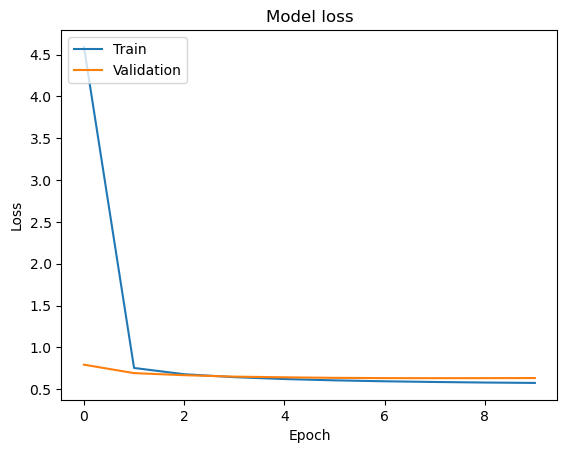

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

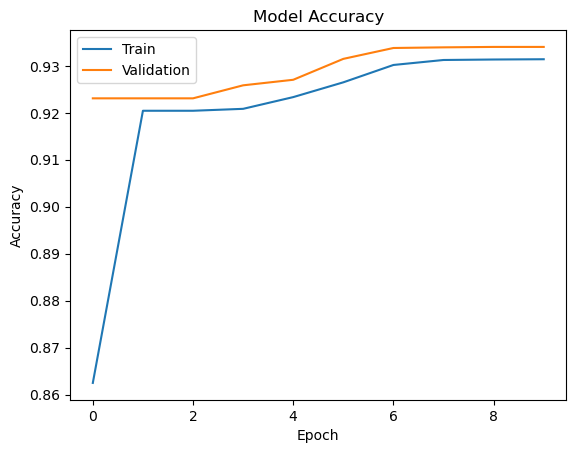

In [90]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [97]:
max(history.history['accuracy'])

0.9313984513282776

In [99]:
max(history.history['val_accuracy'])

0.9340205788612366